# Solving Optimal Transport via Linear Programming methods

Let $P \in \mathbb{R}^{n \times m}$ be a transport map, $C \in  \mathbb{R}^{n \times m}$ be a cost function and $\mu = \mu_1, ..., \mu_n$, $\nu = \nu_1, ..., \nu_m$ are two separate measures.

$$
\begin{align*}
\min_{P_{ij}} \quad & \sum_{i=1}^{n} \sum_{j=1}^{m} C_{ij} P_{ij} \\
\text{subject to} \quad & \sum_{j=1}^{m} P_{ij} = \mu_i \quad \text{for all } i = 1, 2, \ldots, n \\
& \sum_{i=1}^{n} P_{ij} = \nu_j \quad \text{for all } j = 1, 2, \ldots, m \\
& P_{ij} \geq 0 \quad \text{for all } i = 1, 2, \ldots, m \text{ and } j = 1, 2, \ldots, n
\end{align*}
$$

Defines a Linear Programming problem with equality constraints $\sum_{j=1}^{m} P_{ij} = \mu_i$ and $\sum_{i=1}^{n} P_{ij} = \nu_j$

## Linear Programming using MOSEK optimization framework
This setup uses the licensed MOSEK solver for LP.

To use this solver, you need to get license from https://www.mosek.com

In [2]:
import numpy as np
import pulp
import mosek
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

#List of methods
PRIMAL_SIMPLEX = mosek.optimizertype.primal_simplex
DUAL_SIMPLEX = mosek.optimizertype.dual_simplex
INTERIOR_POINT = mosek.optimizertype.intpnt

def solver(method):
    return pulp.MOSEK(msg=0, options={
        mosek.iparam.optimizer: method
    })


def lp_solve_ot(cost_matrix, supply, demand, method=PRIMAL_SIMPLEX):
    cost_matrix = np.array(cost_matrix)
    supply = np.array(supply)
    demand = np.array(demand)
    
    prob = pulp.LpProblem("OT", pulp.LpMinimize)
    
    # Number of supply and demand points
    num_supply, num_demand = cost_matrix.shape
    
    # Decision variables: how much to transport from supply i to demand j
    transport_vars = np.array([[pulp.LpVariable(f'P_{i}_{j}', lowBound=0)
                                for j in range(num_demand)] for i in range(num_supply)])
    
    # Objective function: minimize the total cost
    prob += pulp.lpSum(cost_matrix * transport_vars), "TotalCost"

    # Supply constraints: sum of transports from supply i should be equal to supply[i]
    supply_constraints = [pulp.lpSum(transport_vars[i]) == supply[i] for i in range(num_supply)]
    for i in range(num_supply):
        prob += supply_constraints[i], f"Supply_{i}"

    # Demand constraints: sum of transports to demand j should be equal to demand[j]
    demand_constraints = [pulp.lpSum([transport_vars[i][j] for i in range(num_supply)]) == demand[j] for j in range(num_demand)]
    for j in range(num_demand):
        prob += demand_constraints[j], f"Demand_{j}"


    prob.solve(solver(method))

    if pulp.LpStatus[prob.status] == 'Optimal':
        print("Optimal Solution Found:")
        solution = np.vectorize(pulp.value)(transport_vars)
        print(f"Total Cost: {pulp.value(prob.objective)}")
        return solution
    else:
        print("No Optimal Solution Found")
        return None

    
def lp_solve_trimarginal_ot(cost_matrix, a, b, c, method=PRIMAL_SIMPLEX):
    cost_matrix = np.array(cost_matrix)
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    num_a, num_b, num_c = cost_matrix.shape

    prob = pulp.LpProblem("Trimarginal_OT", pulp.LpMinimize)

    transport_vars = np.array([[pulp.LpVariable(f'P_{i}_{j}_{k}', lowBound=0)
                                for j in range(num_a)] for i in range(num_b) for k in range(num_c)])
    
    for i in range(num_a):
        prob += pulp.lpSum(transport_vars[i, :]) == a[i], f"A_{i}"

    for j in range(num_b):
        prob += pulp.lpSum(transport_vars[:, j]) == b[j], f"B_{j}"

    for k in range (num_c):
        prob += pulp.lpSum(transport_vars[:, j]) == c[k], f"C_{k}"

    prob.solve(solver(method))
    
    if pulp.LpStatus[prob.status] == 'Optimal':
        print("Optimal Solution Found:")
        solution = np.vectorize(pulp.value)(transport_vars)
        print(f"Total Cost: {pulp.value(prob.objective)}")
        return solution
    else:
        print(pulp.LpStatus[prob.status])
        print("No Optimal Solution Found")
        return None
    

    
def lp_solve_dual_ot(cost_matrix, supply, demand, method=PRIMAL_SIMPLEX):
    cost_matrix = np.array(cost_matrix)
    supply = np.array(supply)
    demand = np.array(demand)

    prob = pulp.LpProblem("OT_Dual", pulp.LpMaximize)

    num_supply, num_demand = cost_matrix.shape

    # Dual variables: u for supply constraints, v for demand constraints
    u = np.array([pulp.LpVariable(f'U_{i}') for i in range(num_supply)])
    v = np.array([pulp.LpVariable(f'V_{j}') for j in range(num_demand)])

    # Objective function: maximize the sum of supply and demand variables
    prob += pulp.lpSum([supply[i] * u[i] for i in range(num_supply)]) + \
            pulp.lpSum([demand[j] * v[j] for j in range(num_demand)]), "TotalProfit"
    
    # Constraints: u_i + v_j <= cost_matrix[i, j] for all i, j
    for i in range(num_supply):
        for j in range(num_demand):
            prob += u[i] + v[j] <= cost_matrix[i, j], f"Constraint_{i}_{j}"

    prob.solve(solver(method))
    
    if pulp.LpStatus[prob.status] == 'Optimal':
        print("Optimal Solution Found:")
        values = np.vectorize(pulp.value)
        print(f"Total Cost: {pulp.value(prob.objective)}")
        return values(u), values(v)
    else:
        print("No Optimal Solution Found")
        print(pulp.LpStatus[prob.status])
        return None

## Primal Simplex Algorithm

The primal simplex algorithm is an iterative method for solving linear programming problems. It starts from an initial feasible solution and moves along the edges of the feasible region to find the optimal solution.

### Steps of the Primal Simplex Algorithm

1. **Initialization**: Start with an initial basic feasible solution. For the optimal transport problem, this could be an initial transportation plan that satisfies all supply and demand constraints.

2. **Optimality Test**: Check if the current solution is optimal by examining the reduced costs. If all reduced costs are non-negative, the current solution is optimal.

3. **Pivot Selection**: If the current solution is not optimal, select an entering variable (one with a negative reduced cost) to enter the basis. This corresponds to increasing the amount transported along a certain route.

4. **Determine Leaving Variable**: Determine the leaving variable by performing a ratio test to ensure feasibility. This involves finding which variable should leave the basis to maintain the feasibility of the solution.

5. **Update Solution**: Perform a pivot operation to update the basic feasible solution. This involves adjusting the transportation quantities and updating the basis.

6. **Repeat**: Repeat the optimality test, pivot selection, and update steps until an optimal solution is found.

In [3]:
cost_matrix = [[2, 3, 1], [5, 4, 8]]
supply = [10, 15]
demand = [5, 15, 5]

sol = lp_solve_ot(cost_matrix, supply, demand)
u, v = lp_solve_dual_ot(cost_matrix, supply, demand)

print("Matrix P = \n", sol)
print("Potentials u, v = ", u, v)

Optimal Solution Found:
Total Cost: 75.0
Optimal Solution Found:
Total Cost: 75.0
Matrix P = 
 [[ 5.  0.  5.]
 [ 0. 15.  0.]]
Potentials u, v =  [0. 3.] [2. 1. 1.]


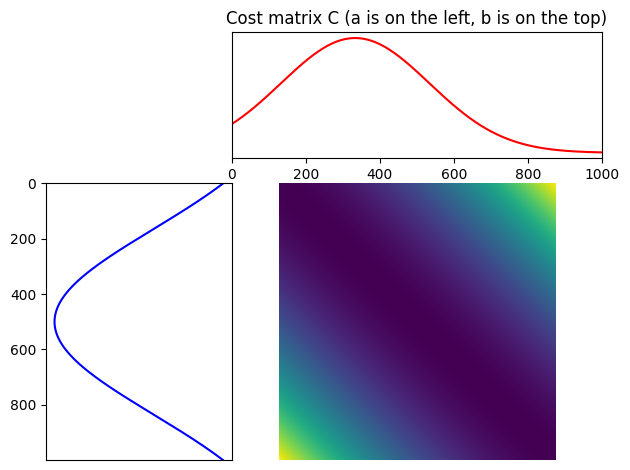

In [4]:
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

n = 1000  # problem size

# Initialize marginals as normal distribution restricted to [0, n], normalized to 1
a = gauss(n, m=n/2, s=n/3)  # m=mean, s=std
b = gauss(n, m=n/3, s=n/5)

# Initialize cost matrix 
x = np.arange(n, dtype=np.float64)
C = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
C = C / C.max()

ot.plot.plot1D_mat(a, b, C, 'Cost matrix C (a is on the left, b is on the top)')

In [5]:
sol = lp_solve_ot(C, a, b, PRIMAL_SIMPLEX)

print(sol)

Optimal Solution Found:
Total Cost: 0.02654454645047023
[[4.48509056e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.42243860e-05 3.76353040e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.50577393e-04 3.02057499e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.54319711e-06
  8.40991029e-06 1.32706299e-05]]


In [6]:
u, v = lp_solve_dual_ot(C, a, b, PRIMAL_SIMPLEX)
print(u,v)

Optimal Solution Found:
Total Cost: 0.026544151400102065
[-0.05245285 -0.05245185 -0.05245085 -0.05244985 -0.05244885 -0.05244784
 -0.05244684 -0.05244384 -0.05244083 -0.05243782 -0.05243482 -0.05243181
 -0.05242881 -0.0524238  -0.05241879 -0.05241378 -0.05240877 -0.05240376
 -0.05239875 -0.05239173 -0.05238472 -0.0523777  -0.05237069 -0.05236367
 -0.05235666 -0.05234764 -0.05233862 -0.05232961 -0.05232059 -0.05231157
 -0.05230055 -0.05228953 -0.0522785  -0.05226748 -0.05225646 -0.05224343
 -0.05223041 -0.05221738 -0.05220436 -0.05219133 -0.0521763  -0.05216127
 -0.05214624 -0.05213121 -0.05211418 -0.05209714 -0.05208011 -0.05206307
 -0.05204604 -0.052027   -0.05200796 -0.05198893 -0.05196989 -0.05194885
 -0.0519278  -0.05190676 -0.05188572 -0.05186468 -0.05184163 -0.05181859
 -0.05179554 -0.05177249 -0.05174744 -0.05172239 -0.05169734 -0.05167229
 -0.05164524 -0.05161818 -0.05159113 -0.05156408 -0.05153502 -0.05150596
 -0.0514769  -0.05144784 -0.05141678 -0.05138572 -0.05135466 -0.051

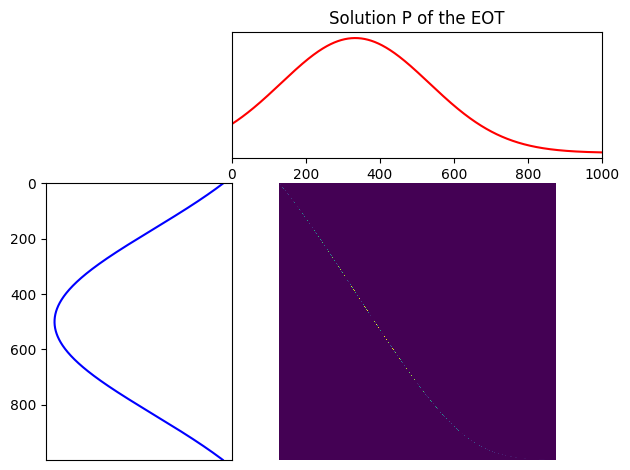

In [7]:
ot.plot.plot1D_mat(a, b, sol, 'Solution P of the EOT')

## Interior point method



In [8]:
sol = lp_solve_ot(C, a, b, INTERIOR_POINT)

print(sol)

Optimal Solution Found:
Total Cost: 0.026544151407687292
[[4.48475735e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.39744718e-05 3.76521924e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.50293640e-04 3.02228449e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.51432905e-06
  8.37412294e-06 8.23601970e-06]]


In [9]:
u, v = lp_solve_dual_ot(C, a, b, INTERIOR_POINT)
print(u,v)

Optimal Solution Found:
Total Cost: 0.026544151407687067
[-0.00000000e+00  1.00200300e-06  2.00400601e-06  3.00600901e-06
  4.00801202e-06  5.01001502e-06  6.01201802e-06  9.01802703e-06
  1.20240360e-05  1.50300451e-05  1.80360541e-05  2.10420631e-05
  2.40480721e-05  2.90580871e-05  3.40681021e-05  3.90781171e-05
  4.40881322e-05  4.90981472e-05  5.41081622e-05  6.11221832e-05
  6.81362042e-05  7.51502253e-05  8.21642463e-05  8.91782673e-05
  9.61922884e-05  1.05210315e-04  1.14228342e-04  1.23246369e-04
  1.32264397e-04  1.41282424e-04  1.52304457e-04  1.63326490e-04
  1.74348523e-04  1.85370556e-04  1.96392589e-04  2.09418628e-04
  2.22444667e-04  2.35470706e-04  2.48496745e-04  2.61522784e-04
  2.76552829e-04  2.91582874e-04  3.06612919e-04  3.21642964e-04
  3.38677015e-04  3.55711066e-04  3.72745117e-04  3.89779169e-04
  4.06813220e-04  4.25851277e-04  4.44889334e-04  4.63927391e-04
  4.82965448e-04  5.04007511e-04  5.25049574e-04  5.46091637e-04
  5.67133700e-04  5.88175763e-04 

## Linear Programming with SCIPY optimization framework

Scipy library is free and requires no license

In [169]:
from scipy.optimize import linprog

#List of methods
SIMPLEX = 'highs-ds'
INTERIOR_POINT = 'highs-ipm'


def scipy_lp_solve_ot(cost_matrix, supply, demand, method=SIMPLEX):
    cost_matrix = np.array(cost_matrix)
    supply = np.array(supply)
    demand = np.array(demand)

    num_supply, num_demand = cost_matrix.shape

    c = cost_matrix.flatten()

    A_eq = np.zeros((num_supply + num_demand, num_supply * num_demand))

    for i in range(num_supply):
        A_eq[i, i*num_demand:(i+1)*num_demand] = 1

    for j in range(num_demand):
        A_eq[num_supply + j, j::num_demand] = 1

    b_eq = np.concatenate([supply, demand])
    
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, method=method)

    if result.success:
        print("Optimal Solution Found:")
        solution = result.x.reshape((num_supply, num_demand))
        print(f"Total Cost: {result.fun}")
        return solution
    else:
        print("No Optimal Solution Found")
        return None
    
def scipy_lp_solve_dual_ot(cost_matrix, supply, demand, method=SIMPLEX):
    cost_matrix = np.array(cost_matrix)
    supply = np.array(supply)
    demand = np.array(demand)

    num_supply, num_demand = cost_matrix.shape

    c = -np.concatenate([supply, demand])

    A_ub = np.zeros((num_supply * num_demand, num_supply + num_demand))

    for i in range(num_supply):
        for j in range(num_demand):
            A_ub[i*num_demand + j, i] = 1  # supply dual variables
            A_ub[i*num_demand + j, num_supply + j] = 1  # demand dual variables

    b_ub = cost_matrix.flatten()

    # Bounds for dual variables are unrestricted (None, None)
    bounds = [(None, None)] * (num_supply + num_demand)
    
    # Solve the linear programming problem
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method=method)
        
    if result.success:
        print("Optimal Solution Found:")
        u = result.x[:num_supply]
        v = result.x[num_supply:]
        print(f"Total Cost: {-result.fun}")
        return u, v
    else:
        print("No Optimal Solution Found")
        return None



In [172]:
cost_matrix = [[2, 3, 1], [5, 4, 8]]
supply = [10, 15]
demand = [5, 15, 5]

sol = scipy_lp_solve_ot(cost_matrix, supply, demand)
u, v = scipy_lp_solve_dual_ot(cost_matrix, supply, demand)

print("Matrix P = \n", sol)
print("Potentials u, v = ", u, v)

Optimal Solution Found:
Total Cost: 75.0
Optimal Solution Found:
Total Cost: 75.0
Matrix P = 
 [[ 5. -0.  5.]
 [ 0. 15.  0.]]
Potentials u, v =  [1. 4.] [ 1. -0.  0.]


In [182]:
c = [-3, -2]

A_ub = [[1, 1], [2, 1]]
b_ub = [[4, 5]]

result = linprog(c, A_ub=A_ub, b_ub=b_ub)

print(result)

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -9.0
              x: [ 1.000e+00  3.000e+00]
            nit: 2
          lower:  residual: [ 1.000e+00  3.000e+00]
                 marginals: [ 0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf]
                 marginals: [ 0.000e+00  0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  0.000e+00]
                 marginals: [-1.000e+00 -1.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0


## Simplex Algorithm

In [177]:
sol = scipy_lp_solve_ot(C, a, b)

print(sol)

Optimal Solution Found:
Total Cost: 0.026544151407687296
[[4.48475735e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.39744718e-05 3.76521924e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.50293640e-04 3.02228449e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.51432905e-06
  8.37412294e-06 8.23601970e-06]]


In [174]:
u, v = scipy_lp_solve_dual_ot(C, a, b)

print(u, v)

Optimal Solution Found:
Total Cost: 0.026544151407687244
(array([-2.82309336e-01, -2.82308334e-01, -2.82307332e-01, -2.82306330e-01,
       -2.82305328e-01, -2.82304326e-01, -2.82303324e-01, -2.82300318e-01,
       -2.82297312e-01, -2.82294306e-01, -2.82291300e-01, -2.82288294e-01,
       -2.82285288e-01, -2.82280278e-01, -2.82275268e-01, -2.82270258e-01,
       -2.82265248e-01, -2.82260238e-01, -2.82255228e-01, -2.82248214e-01,
       -2.82241200e-01, -2.82234186e-01, -2.82227172e-01, -2.82220158e-01,
       -2.82213144e-01, -2.82204126e-01, -2.82195108e-01, -2.82186090e-01,
       -2.82177072e-01, -2.82168054e-01, -2.82157032e-01, -2.82146010e-01,
       -2.82134988e-01, -2.82123966e-01, -2.82112944e-01, -2.82099918e-01,
       -2.82086892e-01, -2.82073866e-01, -2.82060840e-01, -2.82047814e-01,
       -2.82032784e-01, -2.82017753e-01, -2.82002723e-01, -2.81987693e-01,
       -2.81970659e-01, -2.81953625e-01, -2.81936591e-01, -2.81919557e-01,
       -2.81902523e-01, -2.81883485e-01, -

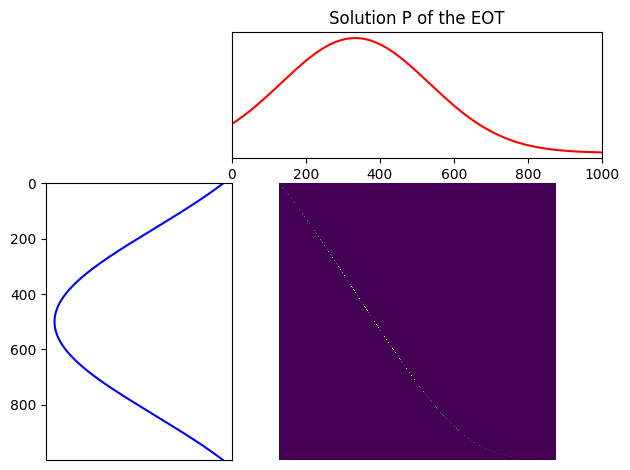

In [178]:
ot.plot.plot1D_mat(a, b, sol, 'Solution P of the EOT')

## Interior Point Method

In [179]:
ol = scipy_lp_solve_ot(C, a, b, method=INTERIOR_POINT)

print(sol)

Optimal Solution Found:
Total Cost: 0.026544151407687296
[[4.48475735e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.39744718e-05 3.76521924e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.50293640e-04 3.02228449e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.51432905e-06
  8.37412294e-06 8.23601970e-06]]


In [180]:
ol = scipy_lp_solve_dual_ot(C, a, b, method=INTERIOR_POINT)

print(sol)

Optimal Solution Found:
Total Cost: 0.02654415140768735
[[4.48475735e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.39744718e-05 3.76521924e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.50293640e-04 3.02228449e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.51432905e-06
  8.37412294e-06 8.23601970e-06]]


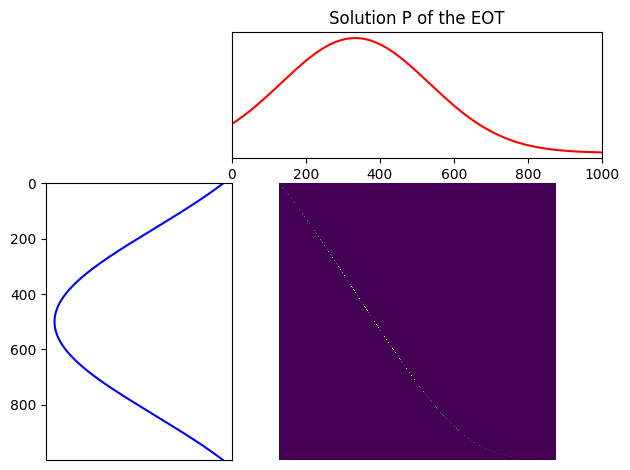

In [181]:
ot.plot.plot1D_mat(a, b, sol, 'Solution P of the EOT')

## Three marginals problem

In [23]:
n = 100
a = gauss(n, m=20, s=5)
b = gauss(n, m=60, s=10)
c = gauss(n, m=10, s=20)

C = np.zeros((n, n, n))

store_coord = 11.
for i in range(n):
    for j in range(n):
        for k in range(n):
            C[i, j, k] = (i - store_coord)**2 + (j - store_coord)**2 + (k - store_coord)**2
C = C / C.max()

solution = lp_solve_trimarginal_ot(C, a, b, c)
print(solution)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : LO (linear optimization problem)
  Constraints            : 300             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 1000001         
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Simplex optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0                 successes              : 0               
Lin. d

### Example 2: Interpolation with $\mathcal{W}_{2}$-distance using Linear Programming methods
___
For the time $t \in (0, 1)$ and given distributions $\mu_0, \mu_1$, we will look for a distribution $\mu_t$ such that
$$
    \mu_t = \arg\min_{\mu} (1 - t) \mathcal{W}^2_2(\mu_0, \mu) + t \mathcal{W}_{2}^2(\mu, \mu_1).
$$

Let's express the Wasserstein distance $W_2^2$ as Optimal transport dual linear problem:

$$
    W_2^2(\mu_0, \mu) = \sum_{i=1}^n u^* \mu_0 + \sum_{j=1}^n v^* \mu
$$

Where $u^*$ and $v^*$ are the optimal solutions for the dual problem. And we can find them using our Linear Programming solver!

Then, we know the variation of the Wasserstein distance by measure $\mu$:

$$
    \nabla_\mu W^2_2(\mu_0, \mu) = v^*
$$
and

$$
    \nabla_\mu W^2_2(\mu, \mu_1) = u^*
$$

So we can construct the itaritve procedure (gradient descent) to find the min of the functional above:

$$
    \mu^{(i+1)}_{t} = \mu_t^{(i)} - \eta ( (1 - t) v^* + t u^* )
$$

/var/folders/ht/k__3wprx33gcrt4tr1m4s5wc0000gn/T/ipykernel_67102/2518228538.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


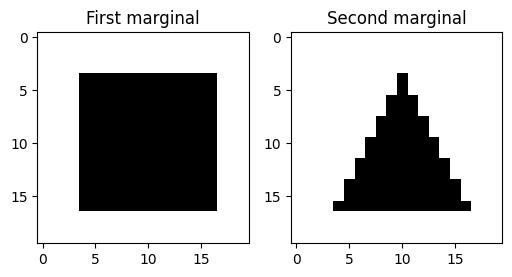

In [16]:
n_snapshots = 5

T = np.linspace(0, 1, n_snapshots)[1:-1]

image_shape = (20, 20)

img = Image.new('L', image_shape, 'white')
draw = ImageDraw.Draw(img)
draw.rectangle([4, 4, 16, 16], fill='black')
a = np.asarray(img)
a = a / a.sum()

# Create an image with white background
img = Image.new('L', image_shape, 'white')
draw = ImageDraw.Draw(img)
triangle_points = [(10, 4), (4, 16), (16, 16)]
draw.polygon(triangle_points, fill="black")
b = np.asarray(img)
b = b / b.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.imshow(a, cmap='gray')
ax1.set_title('First marginal')
ax2.imshow(b, cmap='gray')
ax2.set_title('Second marginal')

fig.show()

In [21]:
def find_barycenter(mu, nu, C, t, iterations = 1, learning_rate = 0.001):
    mu_t = ((1 - t) * mu + t * nu).flatten()
    for i in range(0, iterations):
        mu_t = mu_t / mu_t.sum()
        u_1, v_1 = lp_solve_dual_ot(C, mu.flatten(), mu_t, method=INTERIOR_POINT)
        u_2, v_2 = lp_solve_dual_ot(C, mu_t, nu.flatten(), method=INTERIOR_POINT)
        grad = t * v_1 + (1 - t) * u_2
        w_22 = (1 - t) * (np.dot(u_1, mu.flatten()) + np.dot(v_1, mu_t)) + t * (np.dot(u_2, mu_t) + np.dot(v_2, nu.flatten()))
        mu_t = np.maximum(mu_t - learning_rate * grad, 0)
        print(f"iteration {i}:", w_22)
    return mu_t.reshape(mu.shape)


Optimal Solution Found:
Total Cost: 0.0003473578143012604
Optimal Solution Found:
Total Cost: 0.002279493792069638
iteration 0: 0.0008303918087433537
Optimal Solution Found:
Total Cost: 0.0010995982600641185
Optimal Solution Found:
Total Cost: 0.0010420054616728802
iteration 0: 0.0010708018608684973
Optimal Solution Found:
Total Cost: 0.0023290495222031905
Optimal Solution Found:
Total Cost: 0.0002911490916491673
iteration 0: 0.000800624199287668


/var/folders/ht/k__3wprx33gcrt4tr1m4s5wc0000gn/T/ipykernel_67102/162707318.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


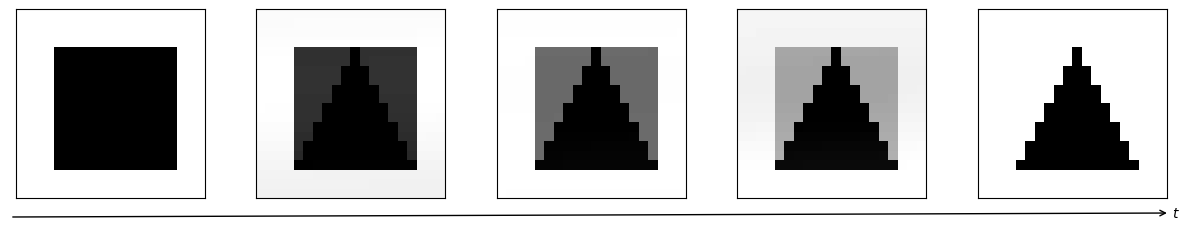

In [22]:
T = [0, .25, 0.5, 0.75, 1.]  # List of regularizations to compute EOT (you can put your own)

n_plots = len(T)


# Create a figure and a list of axes for the subplots
fig, axs = plt.subplots(1, n_plots, figsize=(3*n_plots, 3), sharey=True)


# Put original marginal as the first and the last pictures
axs[0].imshow(a, cmap='gray')
axs[0].set_xticks([])
axs[0].set_xticklabels([])
axs[0].set_yticks([])
axs[0].set_yticklabels([])
axs[-1].imshow(b, cmap='gray')
axs[-1].set_xticks([])
axs[-1].set_xticklabels([])
axs[-1].set_yticks([])
axs[-1].set_yticklabels([])

n = len(a) ** 2
x = np.arange(n)
C = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
C = C / C.max()

for ax, t in zip(axs[1:-1], T[1:-1]):
    interp = find_barycenter(a, b, C, t)
    ax.imshow(interp, cmap='gray')

    # Hide x-axis labels and ticks for individual plots
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

# Create an axis below all subplots for a common axis
fig.subplots_adjust(bottom=0.25)
common_ax = fig.add_subplot(111, label='common', frame_on=False)
common_ax.tick_params(labelcolor='black', top=False, bottom=False, left=False, right=False)
common_ax.set_xticks([])
common_ax.set_yticks([])

# Draw an arrowed axis
common_ax.annotate(r'$t$', xy=(0, -0.1), xytext=(1, -0.1), xycoords='axes fraction', textcoords='axes fraction',
                   arrowprops=dict(arrowstyle="<-", color='black'))

fig.show()